# Dependencies

In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import pandas as pd
import os
from copy import deepcopy
import matplotlib.pyplot as plt
from pyDOE import lhs # Latin Hypercube Sampling

# Check if CUDA is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Parameters and Import Data

In [2]:
file_path = os.getcwd()

Nu = 256
# Nu = 64
Nf = 10000
a, b = 0.0, 1.0

# Load True Solution and paramters
df = pd.read_csv(f'{file_path}/synthetic_data/synthetic_data.csv')
x_array, mtrue_array, utrue_array = np.array(df['x']), np.array(df['mtrue']), np.array(df['utrue'])
forcing_array, dist_array = np.array(df['forcing']), np.array(df['distribution'])
omega = np.array(df['omega'])[0]

from scipy.interpolate import interp1d
true_solution = interp1d(x_array, utrue_array)
true_dist = interp1d(x_array, dist_array)
true_forcing = interp1d(x_array, forcing_array)
omega = torch.tensor(omega, dtype=torch.float32, device=device)

# Set up Training Data

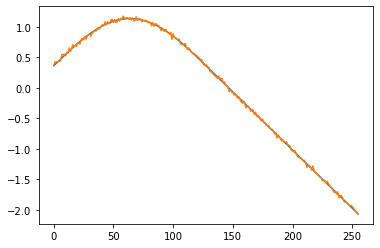

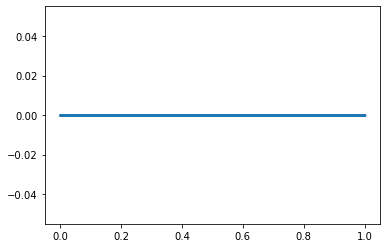

In [3]:
X_u_train = torch.linspace(a,b, Nu, dtype=torch.float32)[:, None]

u_train = torch.tensor(true_solution(X_u_train), dtype=torch.float32)
plt.plot(u_train)
noise_level = 0.01
np.random.seed(0)
u_train += torch.randn(u_train.shape) * abs(u_train).max() * noise_level
plt.plot(u_train)
plt.show()

X_f_train = torch.tensor(lhs(1, Nf), dtype=torch.float32)
dist_f_train = torch.tensor(true_dist(X_f_train), dtype=torch.float32)
forcing_f_train = torch.tensor(true_forcing(X_f_train), dtype=torch.float32)
plt.plot(X_f_train, np.zeros_like(X_f_train), 'o', markersize=1)

# Move data to the selected device
X_u_train = X_u_train.to(device)
u_train = u_train.to(device)
X_f_train = X_f_train.to(device)
X_f_train.requires_grad = True
dist_f_train = dist_f_train.to(device)
forcing_f_train = forcing_f_train.to(device)

# Define Neural Network with Training Loop

In [4]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = layers
        self.num_layers = len(layers)
        self.loss_function = nn.MSELoss()

        # Neural Network
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        self.linears_m = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)]) # separate NN for m since m varies spatially
        self.activation = nn.Tanh()
        
        self.best_loss = 1e10

        # self.m = nn.Parameter(torch.tensor(0.1), requires_grad=True)
        # self.m = torch.tensor(0.0, dtype=torch.float32)

        # Xavier Initialization
        for i in range(len(self.linears)):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.xavier_normal_(self.linears_m[i].weight.data, gain=1.0)
            if self.linears[i].bias is not None:
                nn.init.zeros_(self.linears[i].bias.data)
            if self.linears_m[i].bias is not None:
                nn.init.zeros_(self.linears_m[i].bias.data)
    
    def forward(self, x):
        # print(x.shape)
        a_ = torch.tensor(a, dtype=torch.float32)
        b_ = torch.tensor(b, dtype=torch.float32)
        #preprocessing input 
        x = (x - a_)/(b_ - a_) #feature scaling
        # compute m first
        x_copy = x.clone()
        m = self.m_compute(x_copy)
        
        for i, linear in enumerate(self.linears[:-1]):
            x = self.activation(linear(x))
        x = self.linears[-1](x)  # No activation on the last layer (u)
        return x, m
    
    def m_compute(self, x):
        # print(x.shape)
        a_ = torch.tensor(a, dtype=torch.float32)
        b_ = torch.tensor(b, dtype=torch.float32)
        #preprocessing input 
        
        for i, linear in enumerate(self.linears_m[:-1]):
            x = self.activation(linear(x))
        x = self.linears_m[-1](x)  # No activation on the last layer (u)
        return x
    
    def compute_loss(self, x_u, u_true, x_f):
        x_f.requires_grad = True
        # Calculate u from the network at boundary points and collocation points
        u_f_pred, m_pred = self.forward(x_f)
        
        # Compute f (similar to TensorFlow implementation)
        u_f_pred_grads = torch.autograd.grad(u_f_pred, x_f, grad_outputs=torch.ones_like(u_f_pred), retain_graph=True, create_graph=True)[0]
        u_f_pred_xx = torch.autograd.grad(torch.exp(m_pred) * u_f_pred_grads, x_f, grad_outputs=torch.ones_like(u_f_pred_grads[:,[0]]), create_graph=True)[0]
        # u_f_pred_xx = torch.autograd.grad(u_f_pred_grads, x_f, grad_outputs=torch.ones_like(u_f_pred_grads[:,[0]]), create_graph=True)[0]
        # m_f_pred_grads = torch.autograd.grad(m_pred, x_f, grad_outputs=torch.ones_like(m_pred), create_graph=True)[0]

        rhs = forcing_f_train
        # rhs = (torch.sin(2 * torch.pi * x_f)) 

        # f_pred = - torch.exp(m_pred) * u_f_pred_xx - torch.exp(m_pred) * m_f_pred_grads * u_f_pred_grads + omega * dist_f_train * u_f_pred - rhs
        f_pred = - u_f_pred_xx + omega * dist_f_train * u_f_pred - rhs
        # f_pred = - u_f_pred_xx + 10 * u_f_pred - rhs
        
        # Calculate the loss
        loss_f = self.loss_function(f_pred, torch.zeros_like(f_pred)) # residual loss
        u_pred, _ = self.forward(x_u)
        loss_u = self.loss_function(u_pred, u_true) # boundary loss
        loss = loss_f + loss_u

        return loss, loss_u, loss_f

    def train(self, x_u, u_true, x_f, epochs, lr):
        # Move model to the selected device
        self.to(device) 
        # adam optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=lr,betas=(0.9, 0.999), eps=1e-07)
        
        start_time = time.time()
        for epoch in range(epochs): # loop over the dataset multiple times
            optimizer.zero_grad()
            loss, loss_u, loss_f = self.compute_loss(x_u, u_true, x_f)
            loss.backward()
            optimizer.step()

            if loss < self.best_loss:
                self.best_loss = loss
                self.best_model = deepcopy(self.state_dict())
                self.best_u, self.best_m = self.forward(x_u)
            
            if (epoch+1) % 1000 == 0: # Print the loss every 100 epochs
                end_time = time.time()
                print(f"Epoch {(epoch+1)}, loss_misfit: {loss_u.item():1.2e}, loss_f: {loss_f.item():1.2e}, loss: {loss.item():1.2e}, run time: {end_time - start_time}s")
                start_time = time.time()

# Run Training Loop

In [5]:
layers = [1, 50, 50, 50, 50, 50, 50, 50, 1]
if 'model' not in locals():
    model = PINN(layers)
model.to(device)
epochs = 1000000
learning_rate = 1e-4


In [ ]:
start_time = time.time()
model.train(X_u_train, u_train, X_f_train, epochs, learning_rate)
Adam_time = time.time() - start_time
print('Training time: {:.4f} seconds'.format((Adam_time)))

/g/g20/ho32/venv_PINN_FEM/lib/python3.9/site-packages/torch/autograd/graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1000, loss_misfit: 1.21e+00, loss_f: 8.41e-01, loss: 2.05e+00, run time: 20.36943244934082s
Epoch 2000, loss_misfit: 7.55e-01, loss_f: 2.51e-01, loss: 1.01e+00, run time: 16.685300827026367s
Epoch 3000, loss_misfit: 6.47e-01, loss_f: 7.08e-02, loss: 7.17e-01, run time: 16.297758102416992s
Epoch 4000, loss_misfit: 5.91e-01, loss_f: 6.45e-02, loss: 6.56e-01, run time: 15.762385368347168s
Epoch 5000, loss_misfit: 5.40e-01, loss_f: 6.04e-02, loss: 6.01e-01, run time: 16.36319375038147s
Epoch 6000, loss_misfit: 4.89e-01, loss_f: 5.84e-02, loss: 5.47e-01, run time: 17.094497680664062s
Epoch 7000, loss_misfit: 4.40e-01, loss_f: 9.00e-02, loss: 5.30e-01, run time: 16.545000553131104s
Epoch 8000, loss_misfit: 3.96e-01, loss_f: 7.23e-01, loss: 1.12e+00, run time: 16.34399962425232s
Epoch 9000, loss_misfit: 3.52e-01, loss_f: 5.18e-02, loss: 4.04e-01, run time: 16.37816095352173s
Epoch 10000, loss_misfit: 3.21e-01, loss_f: 5.44e-02, loss: 3.75e-01, run time: 16.886355876922607s
Epoch 11000, 

Adam_time = time.time() - start_time

## LBFGS for Optimization Refinement

In [ ]:
start_time1 = time.time()
## L-BFGS
optimizer = torch.optim.LBFGS(model.parameters(), lr=1, tolerance_grad=1e-10, history_size=100, line_search_fn="strong_wolfe")
def closure():
    optimizer.zero_grad()
    loss, loss_u, loss_f = model.compute_loss(X_u_train, u_train, X_f_train)
    loss.backward()
    return loss
for lbfgs_iter in range(5):
    optimizer.step(closure)
    loss, loss_u, loss_f = model.compute_loss(X_u_train, u_train, X_f_train)
    if loss < model.best_loss:
        model.best_loss = loss
        model.best_model = deepcopy(model.state_dict())
        model.best_u, model.best_m = model.forward(X_u_train)
    print(f"LBFGS: Loss_misfit: {loss_u.item():1.2e}, loss_f: {loss_f.item():1.2e}, loss: {loss.item():1.2e}")
    # print(f"LBFGS: Loss_misfit: {loss_u.item():1.2e}, loss_f: {loss_f.item():1.2e}, loss: {loss.item():1.2e} , exp(m): {np.exp(model.m.item()):.5f}")
LBFGS_time = time.time() - start_time1
print('LBFGS time: {:.4f} seconds'.format((LBFGS_time)))

# Plot Results

In [ ]:
import matplotlib.pyplot as plt

# obtain results after training
u, m = model.best_u, model.best_m #model.forward(X_u_train)
# m = model.m_compute(X_u_train)

# error, error_label = np.sqrt(nmse(np.exp(m.compute_vertex_values()),  np.exp(mtrue_array))), 'NRMSE'
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3.6)) 
ax[0].plot(X_u_train.cpu(),u_train.cpu(), '-', label=f'$u_d$: $n_x = {Nu}$', markersize=2, linewidth=2.5)
ax[0].plot(X_u_train.cpu(),u.detach().cpu(), '--', label=r'$u_{sol}$', markersize=2, linewidth=2.5)
# ax[0].plot(x, u_analytic, 'o', label=r'$A\sin(2\pi x)$', markersize=2, linewidth=2.5)
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$u$')
ax[0].set_title(f'Data $u_d$ vs. Solution $u$: MSE = {loss_u.item():1.2e}', fontsize=15)
ax[0].grid()
ax[0].legend(fontsize=12)
ax[1].plot(x_array, mtrue_array, '-', label=r'$m_{true}$', color='tab:blue', linewidth=2.5)
# ax[1].plot(X_u_train,np.ones(Nu), '-', label=r'$m_{true}$', color='tab:blue', linewidth=2.5)
ax[1].plot(X_u_train.cpu(),m.detach().cpu(), '--', label=r'$m_{sol}$', color='tab:red', linewidth=2.5)
# ax[1].set_title(f'gamma = {gamma[kappa_min_ind]:.3e}')
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$m$')
ax[1].set_title(f'Recovered vs. True Param', fontsize=15)
ax[1].grid()
ax[1].legend(fontsize=12)

ax[2].plot(X_u_train.cpu(), abs(u_train.cpu() - u.detach().cpu()))
# ax[2].plot(x, run.g_sun.compute_vertex_values())
ax[2].set_title(f'Data Misfit: \n $|u - u_d|$', fontsize=15)
ax[2].set_xlabel(r'$x$')
ax[2].set_ylabel(r'$|u_{sol} - u_d|$')
ax[2].grid()

print(f'MSE = {torch.mean((u_train.cpu() - u.detach().cpu())**2)}')
# plt.savefig('Helm.png', dpi=300)
plt.show()

# Save Results

In [16]:
import sys
import json
sys.path.append('./../')
from utils import increment_path

In [17]:
dir_name = "Notebook_PINN_results"
path_ = f'./log/{dir_name}'
if 'save_path' not in locals():
    save_path = increment_path(path_, mkdir=True)
print(save_path)

log/Notebook_PINN_results06


In [18]:
# define results dict
results = {
    'adam_runtime': Adam_time,
    'lbfgs_runtime': LBFGS_time,
    'x_u_train': X_u_train.cpu().tolist(),
    'u_train': u_train.cpu().tolist(),
    'u_sol': u.detach().cpu().tolist(),
    'm_sol': m.detach().cpu().tolist(),
    'x_for_m_true': x_array.tolist(),
    'm_true': mtrue_array.tolist(),
}

In [19]:
with open(f'{save_path}/results.json', 'w') as f:
    json.dump(results, f, indent=2)

In [20]:
torch.save(model,f'{save_path}/model.pt')

In [14]:
layers = [1, 50, 50, 50, 50, 50, 50, 1]
test_model = PINN(layers)
test_model.load_state_dict(torch.load(f'{save_path}/model.pt', weights_only=True))

test_model.to(device)

FileNotFoundError: [Errno 2] No such file or directory: 'log/Notebook_PINN_results04/model.pt'

MSE = 0.0007030429551377892


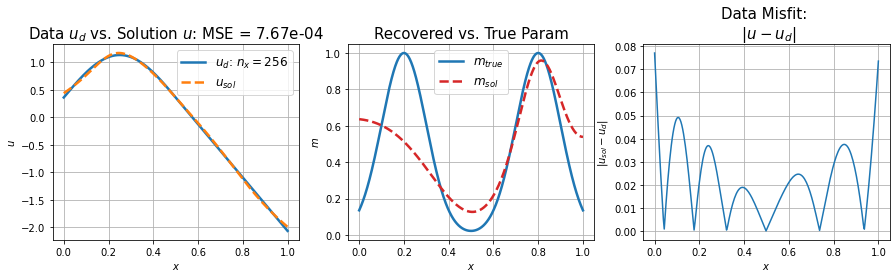

In [26]:
# obtain results after training
u, m = test_model.forward(X_u_train)
# m = model.m_compute(X_u_train)

# error, error_label = np.sqrt(nmse(np.exp(m.compute_vertex_values()),  np.exp(mtrue_array))), 'NRMSE'
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3.6)) 
ax[0].plot(X_u_train.cpu(),u_train.cpu(), '-', label=f'$u_d$: $n_x = {Nu}$', markersize=2, linewidth=2.5)
ax[0].plot(X_u_train.cpu(),u.detach().cpu(), '--', label=r'$u_{sol}$', markersize=2, linewidth=2.5)
# ax[0].plot(x, u_analytic, 'o', label=r'$A\sin(2\pi x)$', markersize=2, linewidth=2.5)
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$u$')
ax[0].set_title(f'Data $u_d$ vs. Solution $u$: MSE = {loss_u.item():1.2e}', fontsize=15)
ax[0].grid()
ax[0].legend(fontsize=12)
ax[1].plot(x_array, mtrue_array, '-', label=r'$m_{true}$', color='tab:blue', linewidth=2.5)
# ax[1].plot(X_u_train,np.ones(Nu), '-', label=r'$m_{true}$', color='tab:blue', linewidth=2.5)
ax[1].plot(X_u_train.cpu(),m.detach().cpu(), '--', label=r'$m_{sol}$', color='tab:red', linewidth=2.5)
# ax[1].set_title(f'gamma = {gamma[kappa_min_ind]:.3e}')
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$m$')
ax[1].set_title(f'Recovered vs. True Param', fontsize=15)
ax[1].grid()
ax[1].legend(fontsize=12)

ax[2].plot(X_u_train.cpu(), abs(u_train.cpu() - u.detach().cpu()))
# ax[2].plot(x, run.g_sun.compute_vertex_values())
ax[2].set_title(f'Data Misfit: \n $|u - u_d|$', fontsize=15)
ax[2].set_xlabel(r'$x$')
ax[2].set_ylabel(r'$|u_{sol} - u_d|$')
ax[2].grid()

print(f'MSE = {torch.mean((u_train.cpu() - u.detach().cpu())**2)}')
# plt.savefig('Helm.png', dpi=300)
plt.show()

In [52]:
test_model = PINN(layers)#.to(device)

In [53]:
test_model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [54]:
import matplotlib.pyplot as plt

# obtain results after training
u, m = test_model.forward(X_u_train)
# m = model.m_compute(X_u_train)

# error, error_label = np.sqrt(nmse(np.exp(m.compute_vertex_values()),  np.exp(mtrue_array))), 'NRMSE'
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3.6)) 
ax[0].plot(X_u_train.cpu(),u_train.cpu(), '-', label=f'$u_d$: $n_x = {Nu}$', markersize=2, linewidth=2.5)
ax[0].plot(X_u_train.cpu(),u.detach().cpu(), '--', label=r'$u_{sol}$', markersize=2, linewidth=2.5)
# ax[0].plot(x, u_analytic, 'o', label=r'$A\sin(2\pi x)$', markersize=2, linewidth=2.5)
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$u$')
ax[0].set_title(f'Data $u_d$ vs. Solution $u$: MSE = {loss_u.item():1.2e}', fontsize=15)
ax[0].grid()
ax[0].legend(fontsize=12)
ax[1].plot(x_array, mtrue_array, '-', label=r'$m_{true}$', color='tab:blue', linewidth=2.5)
# ax[1].plot(X_u_train,np.ones(Nu), '-', label=r'$m_{true}$', color='tab:blue', linewidth=2.5)
ax[1].plot(X_u_train.cpu(),m.detach().cpu(), '--', label=r'$m_{sol}$', color='tab:red', linewidth=2.5)
# ax[1].set_title(f'gamma = {gamma[kappa_min_ind]:.3e}')
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$m$')
ax[1].set_title(f'Recovered vs. True Param', fontsize=15)
ax[1].grid()
ax[1].legend(fontsize=12)

ax[2].plot(X_u_train.cpu(), abs(u_train.cpu() - u.detach().cpu()))
# ax[2].plot(x, run.g_sun.compute_vertex_values())
ax[2].set_title(f'Data Misfit: \n $|u - u_d|$', fontsize=15)
ax[2].set_xlabel(r'$x$')
ax[2].set_ylabel(r'$|u_{sol} - u_d|$')
ax[2].grid()

print(f'MSE = {torch.mean((u_train.cpu() - u.detach().cpu())**2)}')
# plt.savefig('Helm.png', dpi=300)
plt.show()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

# Simpler Example

In [2]:
import torch
import torch.nn as nn
import numpy as np
import time
import pandas as pd
import os
from copy import deepcopy
from pyDOE import lhs # Latin Hypercube Sampling

In [3]:
# Check if CUDA is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [6]:
Nu = 256
Nf = 1000
a, b = 0.0, 1.0

def true_solution(x):
    return np.sin(2 * torch.pi * x) / ((2* torch.pi)**2 + 10)

X_u_train = torch.linspace(a,b, Nu, dtype=torch.float32)[:, None].to(device)
X_f_train = torch.tensor(lhs(1, Nf), dtype=torch.float32).to(device)
u_train = true_solution(X_u_train)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.